In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna

In [117]:
df_weather_hourly = pd.read_parquet(r'..\data\01_interim\weather_hourly_darksky_cleaned.parquet')

In [118]:
df_consumption_hourly = pd.read_parquet(r'..\data\02_processed\parquet\group_4_half_hourly.parquet')

In [119]:
df_consumption_hourly = df_consumption_hourly.drop(columns=['Date','Acorn_grouped'])

In [120]:
def create_features(weather_df, consumption_df):
    if 'Date' in consumption_df.columns:
        consumption_df = consumption_df.drop(columns=['Date'])
    if 'Acorn_grouped' in consumption_df.columns:
        consumption_df = consumption_df.drop(columns=['Acorn_grouped'])
    df = pd.merge(weather_df, consumption_df, left_index=True, right_on='DateTime').reset_index(drop=True)
    df = df.drop(columns='apparentTemperature')
    holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
    holidays = pd.to_datetime(holidays['Bank holidays'])
    df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)
    df["hour"]      = df["DateTime"].dt.hour
    df["dayofweek"] = df["DateTime"].dt.dayofweek
    df["month"]     = df["DateTime"].dt.month
    df["dayofyear"] = df["DateTime"].dt.day_of_year
    df['is_holiday'] = df['is_holiday'].astype(int)

    return df

### Test set: last 48h

In [121]:
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

In [122]:
df = df.drop(columns='apparentTemperature')

In [123]:
holidays = pd.read_csv(r'..\data\00_raw\uk_bank_holidays.csv')
holidays = pd.to_datetime(holidays['Bank holidays'])
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)

In [124]:
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.day_of_year
df['is_holiday'] = df['is_holiday'].astype(int)

In [125]:
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

group_sizes = {
    ac: grp["group_idx"].max() + 1
    for ac, grp in df.groupby("Acorn")
}

# Mark the final 96 half‐hour rows (48h) of each ACORN as test
horizon_steps = 48 * 2  # 96 half‐hour rows
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_steps),
    axis=1
)

# Split into df_train and df_test
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (96 × #ACORN): {len(df_test)}\n")

Total rows: 80796
Training rows: 80508
Test rows (96 × #ACORN): 288



In [126]:
numeric_features = [
    "visibility","windBearing","temperature","dewPoint","pressure",
    "windSpeed","humidity","hour","dayofweek","month",
    "dayofyear","is_holiday"
]
categorical_features = ["precipType","icon"]


=== Training Random Forest for ACORN = ACORN-C ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0241, MAE = 0.0176, , MAPE = 1.7611 %

=== Training Random Forest for ACORN = ACORN-F ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0170, MAE = 0.0135, , MAPE = 1.3513 %

=== Training Random Forest for ACORN = ACORN-P ===
  Train size = 26836, Test size = 96
  → Test RMSE = 0.0196, MAE = 0.0155, , MAPE = 1.5497 %

--- Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7321
    num__temperature                0.1455
    num__dayofyear                  0.0503
    num__dayofweek                  0.0121
    num__humidity                   0.0095
    num__pressure                   0.0085
    num__windSpeed                  0.0080
    cat__icon_partly-cloudy-day     0.0072
    num__visibility                 0.0065
    num__windBearing                0.0064


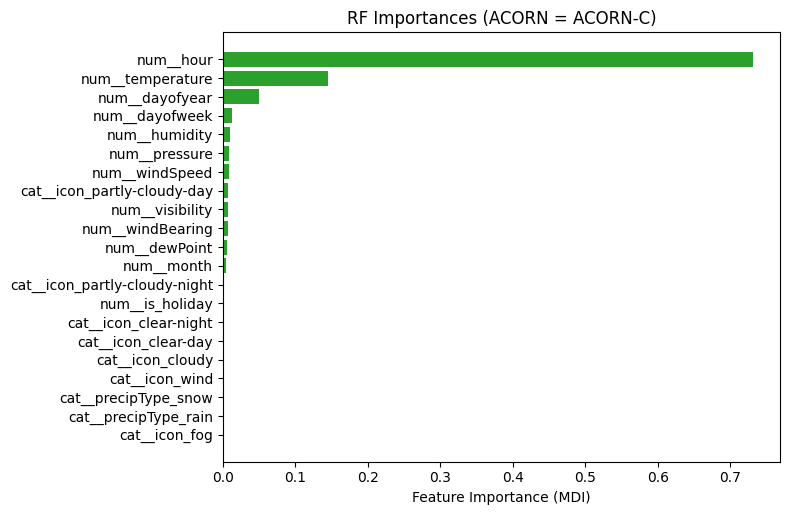

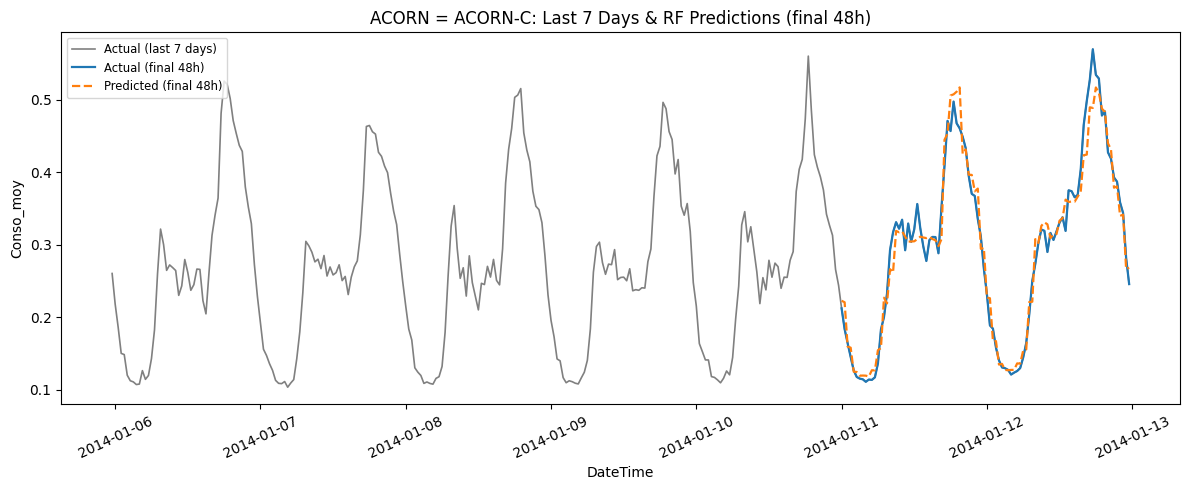


--- Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7044
    num__temperature                0.1888
    num__dayofyear                  0.0522
    num__dayofweek                  0.0193
    num__windSpeed                  0.0049
    num__pressure                   0.0046
    num__dewPoint                   0.0043
    num__month                      0.0043
    num__humidity                   0.0042
    num__visibility                 0.0041


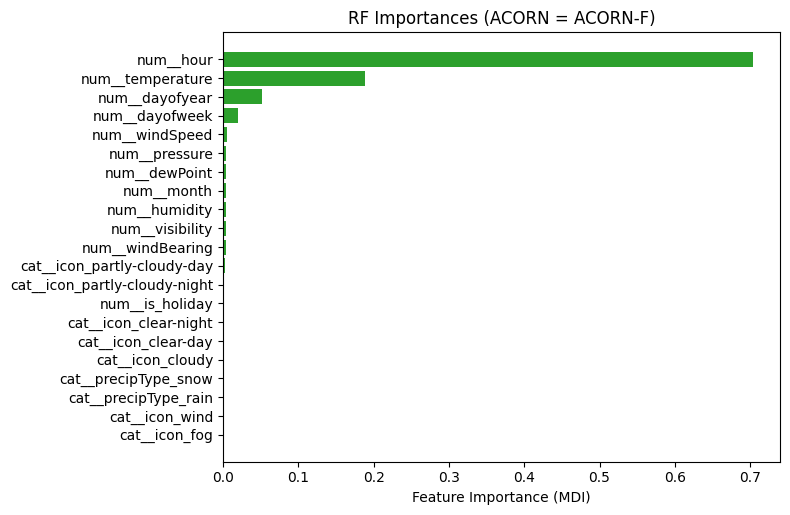

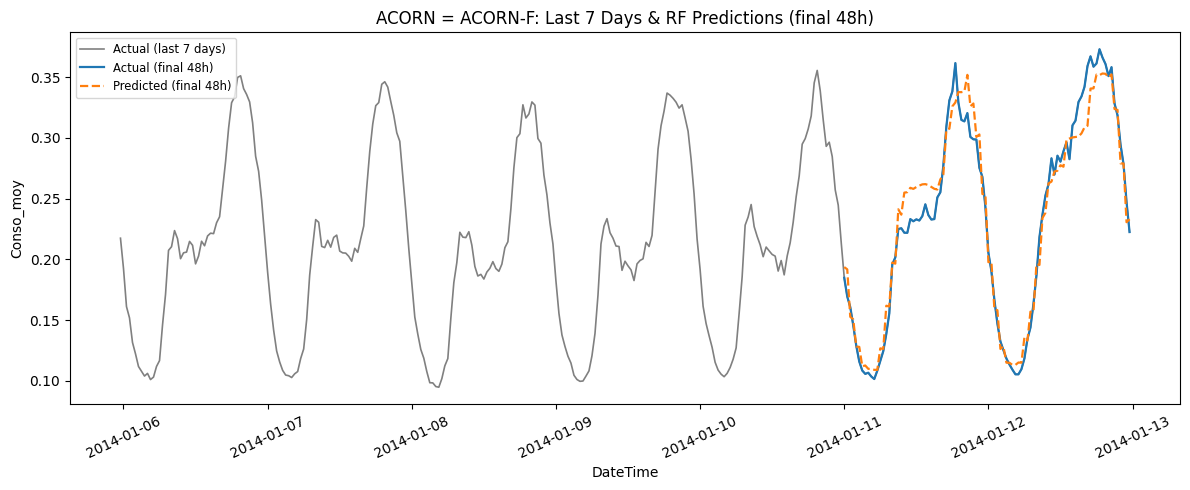


--- Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5935
    num__temperature                0.1709
    num__dayofyear                  0.1038
    num__pressure                   0.0209
    num__visibility                 0.0209
    num__windBearing                0.0200
    num__windSpeed                  0.0194
    num__dewPoint                   0.0181
    num__humidity                   0.0111
    num__dayofweek                  0.0078


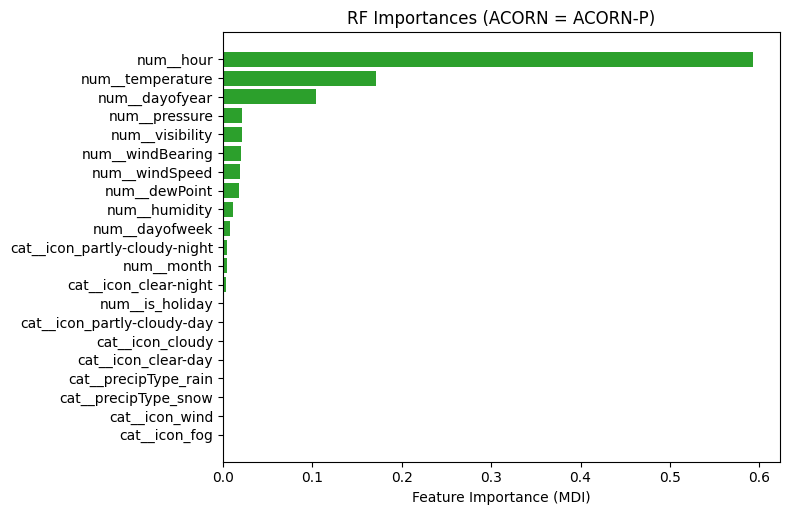

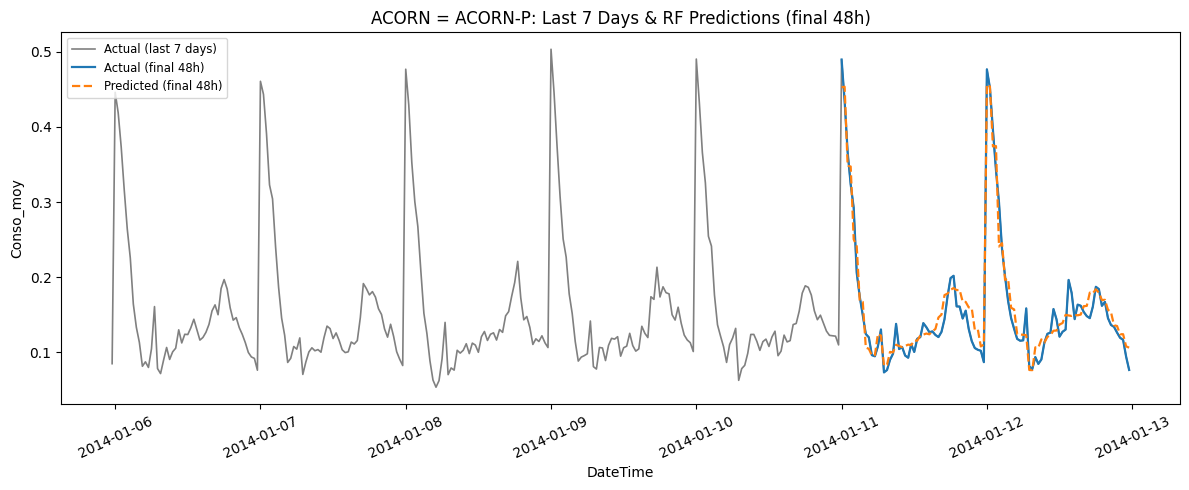

In [127]:
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== Training Random Forest for ACORN = {acorn_label} ===")
    
    # 5.1) Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # 5.2) Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # 5.3) Build ColumnTransformer (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # 5.4) Build Pipeline: Preprocessor → RandomForest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", rf),
    ])
    
    # 5.5) Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)
    
    # 5.6) Predict on this ACORN’s test set (final 48h)
    y_pred_sub = pipe.predict(X_test_sub)
    
    # 5.7) Compute RMSE / MAE on held‐out 48h
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, , MAPE = {100*mae_sub:.4f} %")
    
    # 5.8) Store results
    results_rf[acorn_label] = {
        "pipeline":   pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }

# ──────────────────────────────────────────────────────────────────────────────
# 6) FEATURE IMPORTANCE AND PLOTTING LAST 7 DAYS PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # 6.A) FEATURE IMPORTANCE
    print(f"\n--- Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # 6.A.1) Retrieve post-transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # 6.A.2) Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # 6.B) PLOT LAST 7 DAYS WITH FINAL 48h PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last 7 days (gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="gray",
        linewidth=1.2
    )
    # Actual final 48h (blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final 48h)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final 48h (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final 48h)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 7 Days & RF Predictions (final 48h)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

### Test set: last week

In [115]:
# ──────────────────────────────────────────────────────────────────────────────
df = pd.merge(df_weather_hourly, df_consumption_hourly, left_index=True, right_on='DateTime').reset_index(drop=True)

# Extract hour, day of week, month, and day of year
df["hour"]      = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"]     = df["DateTime"].dt.month
df["dayofyear"] = df["DateTime"].dt.dayofyear
df = df.drop(columns='apparentTemperature')
df['is_holiday'] = df['DateTime'].dt.date.isin(holidays.dt.date)


# ──────────────────────────────────────────────────────────────────────────────
# SORT BY ACORN & DATETIME, ASSIGN WITHIN‐GROUP INDEX, AND SPLIT FINAL WEEK AS TEST
# ──────────────────────────────────────────────────────────────────────────────
df = df.sort_values(["Acorn", "DateTime"]).reset_index(drop=True)
df["group_idx"] = df.groupby("Acorn").cumcount()

# Compute each ACORN group’s size
group_sizes = {
    ac: grp["group_idx"].max() + 1
    for ac, grp in df.groupby("Acorn")
}

# Mark the final week (7 days = 7*48 half‐hour rows = 336) of each ACORN as test
horizon_steps = 7 * 48  # 336 half‐hour rows
df["is_test"] = df.apply(
    lambda row: row["group_idx"] >= (group_sizes[row["Acorn"]] - horizon_steps),
    axis=1
)

# Split into df_train and df_test
df_train = df[df["is_test"] == False].copy()
df_test  = df[df["is_test"] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Training rows: {len(df_train)}")
print(f"Test rows (336 × #ACORN): {len(df_test)}\n")

# ──────────────────────────────────────────────────────────────────────────────
# DEFINE FEATURE COLUMNS
# ──────────────────────────────────────────────────────────────────────────────
numeric_features = [
    "visibility","windBearing","temperature","dewPoint","pressure",
    "windSpeed","humidity","hour","dayofweek","month",
    "dayofyear","is_holiday"
]
categorical_features = ["precipType","icon"]

# ──────────────────────────────────────────────────────────────────────────────
# LOOP OVER EACH ACORN TO TRAIN A RF WITH DEFAULT HYPERPARAMETERS
# ──────────────────────────────────────────────────────────────────────────────
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== Training Random Forest for ACORN = {acorn_label} ===")
    
    # Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # Build ColumnTransformer (no “Acorn” in categorical_features)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # Build Pipeline: Preprocessor → RandomForest
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", rf),
    ])
    
    # Fit on this ACORN’s training data
    pipe.fit(X_train_sub, y_train_sub)
    
    # Predict on this ACORN’s test set (final week)
    y_pred_sub = pipe.predict(X_test_sub)
    
    # Compute RMSE / MAE on held‐out week
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    print(f"  → Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}")
    
    # Store results
    results_rf[acorn_label] = {
        "pipeline":   pipe,
        "X_test_sub": X_test_sub,
        "y_test_sub": y_test_sub.values,
        "y_pred_sub": y_pred_sub,
        "df_test_sub": sub_test,
    }

# ──────────────────────────────────────────────────────────────────────────────
# FEATURE IMPORTANCE AND PLOTTING LAST WEEK PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # FEATURE IMPORTANCE
    print(f"\n--- Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # Retrieve post-transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # PLOT LAST WEEK WITH FINAL WEEK’S PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last week (light gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last week)",
        color="lightgray",
        linewidth=1.2
    )
    # Actual final week (blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Week of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


Total rows: 80796
Training rows: 79788
Test rows (336 × #ACORN): 1008


=== Training Random Forest for ACORN = ACORN-C ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0261, MAE = 0.0197

=== Training Random Forest for ACORN = ACORN-F ===
  Train size = 26596, Test size = 336
  → Test RMSE = 0.0148, MAE = 0.0118

=== Training Random Forest for ACORN = ACORN-P ===
  Train size = 26596, Test size = 336


KeyboardInterrupt: 

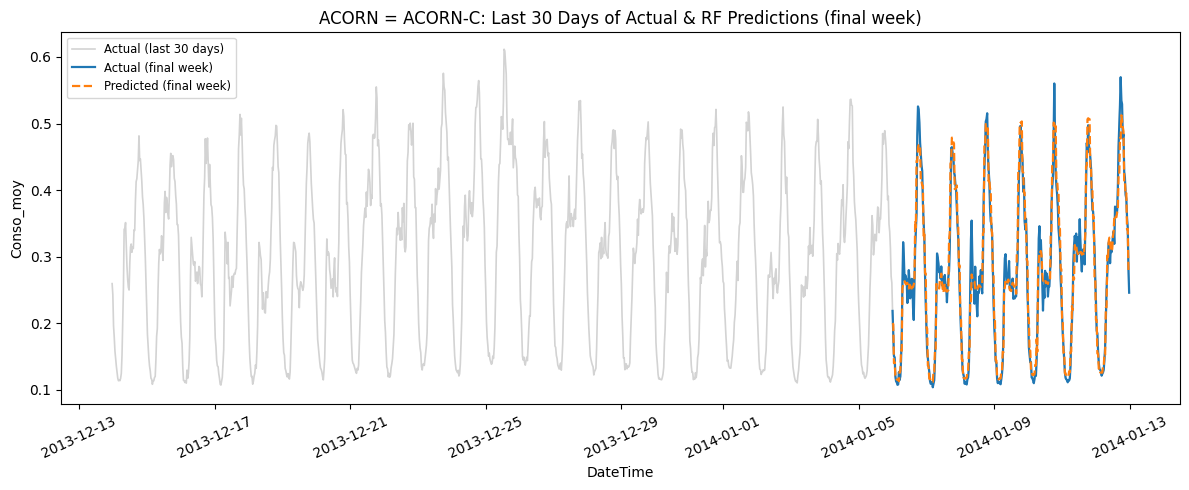

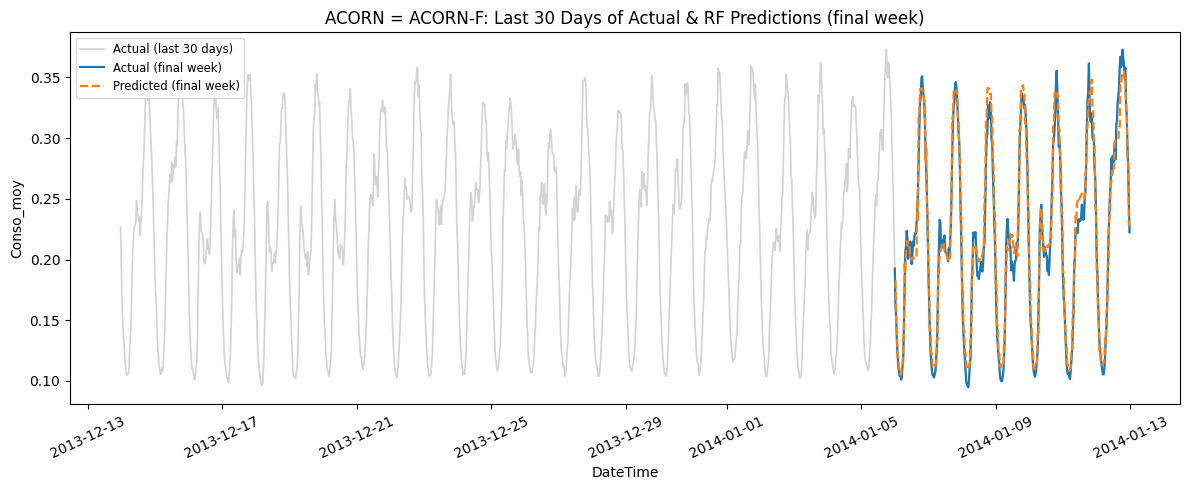

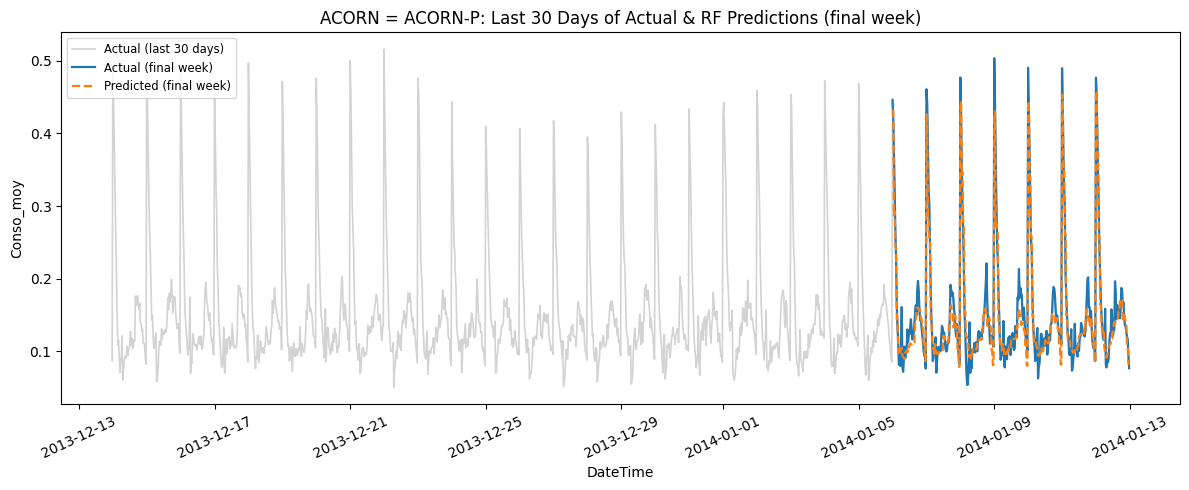

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Plot the last month of actual consumption and overlay the final week’s RF predictions
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results_rf.items():
    # 1) Full history for this ACORN, sorted by DateTime
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    
    # 2) Compute one month ago (30 days)
    one_month_ago = last_timestamp - pd.Timedelta(days=30)
    
    # 3) Filter to only the last 30 days of actual consumption
    last_month_df = full_group[full_group["DateTime"] >= one_month_ago].reset_index(drop=True)
    
    # 4) Extract the final week test subset and its predictions
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    # 5) Plot
    plt.figure(figsize=(12, 5))
    
    # 5A) Last 30 days actual (light gray)
    plt.plot(
        last_month_df["DateTime"],
        last_month_df["Conso_moy"],
        label="Actual (last 30 days)",
        color="lightgray",
        linewidth=1.2
    )
    
    # 5B) Actual final week (solid blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    
    # 5C) RF predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 30 Days of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


### Hyperparameter tuning

In [ ]:
results_rf = {}

for acorn_label in df_train["Acorn"].unique():
    print(f"\n=== TUNING & TRAINING RF FOR ACORN = {acorn_label} ===")
    
    # 5.1) Subset this ACORN’s train/test
    sub_train = df_train[df_train["Acorn"] == acorn_label].copy().reset_index(drop=True)
    sub_test  = df_test [df_test ["Acorn"] == acorn_label].copy().reset_index(drop=True)
    
    # 5.2) Extract X_train_sub, y_train_sub, X_test_sub, y_test_sub
    y_train_sub = sub_train["Conso_moy"].astype(float)
    y_test_sub  = sub_test ["Conso_moy"].astype(float)
    
    drop_cols = ["Conso_moy","group_idx","is_test","Acorn","DateTime"]
    X_train_sub = sub_train.drop(columns=drop_cols)
    X_test_sub  = sub_test .drop(columns=drop_cols)
    
    print(f"  Train size = {len(X_train_sub)}, Test size = {len(X_test_sub)}")
    
    # 5.3) Build ColumnTransformer (no “Acorn”)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop"
    )
    
    # 5.4) Define Optuna objective for this ACORN
    def objective(trial):
        n_estimators     = trial.suggest_int("n_estimators", 50, 300)
        max_depth        = trial.suggest_int("max_depth", 5, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf  = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features     = trial.suggest_categorical("max_features", ["sqrt","log2",None])
        
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )
        pipe = Pipeline([
            ("preproc", preprocessor),
            ("rf", rf),
        ])
        
        tscv = TimeSeriesSplit(n_splits=3)
        neg_rmse = cross_val_score(
            pipe,
            X_train_sub,
            y_train_sub,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )
        # cross_val_score returns negative RMSE; convert to positive
        rmse_scores = -neg_rmse
        return float(rmse_scores.mean())
    
    # 5.5) Run Optuna search for this ACORN
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, n_jobs=6, show_progress_bar=True)
    
    best_params = study.best_params
    print(f"  → Best params: {best_params}")
    print(f"  → Best CV‐RMSE = {study.best_value:.4f}")
    
    # 5.6) Rebuild pipeline with best hyperparameters
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=42,
        n_jobs=-1
    )
    best_pipe = Pipeline([
        ("preproc", preprocessor),
        ("rf", best_rf),
    ])
    
    # 5.7) Fit on full train subset for this ACORN
    best_pipe.fit(X_train_sub, y_train_sub)
    
    # 5.8) Predict on test subset (final week)
    y_pred_sub = best_pipe.predict(X_test_sub)
    
    # 5.9) Compute RMSE / MAE on held‐out week
    rmse_sub = np.sqrt(mean_squared_error(y_test_sub, y_pred_sub))
    mae_sub  = mean_absolute_error(y_test_sub, y_pred_sub)
    mape_sub  = mean_absolute_percentage_error(y_test_sub, y_pred_sub)
    print(f"  → Held‐out week Test RMSE = {rmse_sub:.4f}, MAE = {mae_sub:.4f}, MAPE = {100*mape_sub:.4f} %")
    
    # 5.10) Store results
    results_rf[acorn_label] = {
        "best_params":  best_params,
        "cv_rmse":      study.best_value,
        "test_rmse":    rmse_sub,
        "test_mae":     mae_sub,
        "pipeline":     best_pipe,
        "X_test_sub":   X_test_sub,
        "y_test_sub":   y_test_sub.values,
        "y_pred_sub":   y_pred_sub,
        "df_test_sub":  sub_test,
    }


[I 2025-06-06 01:14:42,591] A new study created in memory with name: no-name-c3943d86-8c3d-4ccd-845f-ed0a0e3ef207



=== TUNING & TRAINING RF FOR ACORN = ACORN-C ===
  Train size = 26596, Test size = 336


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 1. Best value: 0.0625348:   2%|▏         | 1/50 [00:09<07:44,  9.48s/it]

[I 2025-06-06 01:14:52,060] Trial 1 finished with value: 0.06253481230959596 and parameters: {'n_estimators': 93, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.06253481230959596.


Best trial: 2. Best value: 0.0618861:   4%|▍         | 2/50 [00:10<03:48,  4.76s/it]

[I 2025-06-06 01:14:53,529] Trial 2 finished with value: 0.061886133873213595 and parameters: {'n_estimators': 210, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.061886133873213595.


Best trial: 0. Best value: 0.0575593:   6%|▌         | 3/50 [00:16<04:00,  5.11s/it]

[I 2025-06-06 01:14:58,918] Trial 0 finished with value: 0.05755926070129486 and parameters: {'n_estimators': 191, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:   8%|▊         | 4/50 [00:18<02:57,  3.87s/it]

[I 2025-06-06 01:15:01,019] Trial 4 finished with value: 0.060771435242172454 and parameters: {'n_estimators': 149, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:  10%|█         | 5/50 [00:19<02:16,  3.03s/it]

[I 2025-06-06 01:15:02,577] Trial 5 finished with value: 0.06062069516272176 and parameters: {'n_estimators': 292, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:  12%|█▏        | 6/50 [00:21<01:44,  2.37s/it]

[I 2025-06-06 01:15:03,652] Trial 7 finished with value: 0.06159507233372705 and parameters: {'n_estimators': 54, 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:  14%|█▍        | 7/50 [00:23<01:40,  2.33s/it]

[I 2025-06-06 01:15:05,899] Trial 6 finished with value: 0.06006522398600531 and parameters: {'n_estimators': 206, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:  16%|█▌        | 8/50 [00:26<01:46,  2.55s/it]

[I 2025-06-06 01:15:08,913] Trial 8 finished with value: 0.062165178189778784 and parameters: {'n_estimators': 241, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:  18%|█▊        | 9/50 [00:27<01:29,  2.19s/it]

[I 2025-06-06 01:15:10,326] Trial 9 finished with value: 0.061289072576380645 and parameters: {'n_estimators': 185, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 0. Best value: 0.0575593:  20%|██        | 10/50 [00:31<01:49,  2.75s/it]

[I 2025-06-06 01:15:14,323] Trial 10 finished with value: 0.060322463980897766 and parameters: {'n_estimators': 252, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.05755926070129486.


Best trial: 3. Best value: 0.0549128:  22%|██▏       | 11/50 [00:32<01:18,  2.02s/it]

[I 2025-06-06 01:15:14,674] Trial 3 finished with value: 0.05491278229123561 and parameters: {'n_estimators': 272, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  24%|██▍       | 12/50 [00:32<00:59,  1.58s/it]

[I 2025-06-06 01:15:15,254] Trial 11 finished with value: 0.06058877069429224 and parameters: {'n_estimators': 191, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  26%|██▌       | 13/50 [00:33<00:49,  1.34s/it]

[I 2025-06-06 01:15:16,049] Trial 12 finished with value: 0.0656729843017388 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  28%|██▊       | 14/50 [00:34<00:47,  1.32s/it]

[I 2025-06-06 01:15:17,259] Trial 14 finished with value: 0.062138659050627175 and parameters: {'n_estimators': 53, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  30%|███       | 15/50 [00:47<02:48,  4.82s/it]

[I 2025-06-06 01:15:30,246] Trial 13 finished with value: 0.0610568677289002 and parameters: {'n_estimators': 258, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  32%|███▏      | 16/50 [00:49<02:13,  3.92s/it]

[I 2025-06-06 01:15:32,069] Trial 15 finished with value: 0.07005120988695183 and parameters: {'n_estimators': 140, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  34%|███▍      | 17/50 [00:53<02:06,  3.84s/it]

[I 2025-06-06 01:15:35,732] Trial 17 finished with value: 0.06954920630445212 and parameters: {'n_estimators': 299, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  36%|███▌      | 18/50 [00:53<01:32,  2.89s/it]

[I 2025-06-06 01:15:36,398] Trial 16 finished with value: 0.06958949455617 and parameters: {'n_estimators': 298, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  38%|███▊      | 19/50 [01:06<02:56,  5.69s/it]

[I 2025-06-06 01:15:48,461] Trial 18 finished with value: 0.0696145633320956 and parameters: {'n_estimators': 276, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  40%|████      | 20/50 [01:07<02:14,  4.47s/it]

[I 2025-06-06 01:15:50,210] Trial 19 finished with value: 0.0695818068401189 and parameters: {'n_estimators': 298, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  42%|████▏     | 21/50 [01:16<02:48,  5.80s/it]

[I 2025-06-06 01:15:59,144] Trial 20 finished with value: 0.06958507621619929 and parameters: {'n_estimators': 297, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  44%|████▍     | 22/50 [01:24<02:58,  6.38s/it]

[I 2025-06-06 01:16:06,868] Trial 21 finished with value: 0.057701596831887116 and parameters: {'n_estimators': 290, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  46%|████▌     | 23/50 [01:28<02:33,  5.68s/it]

[I 2025-06-06 01:16:10,929] Trial 22 finished with value: 0.05783925848548871 and parameters: {'n_estimators': 226, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  48%|████▊     | 24/50 [01:33<02:24,  5.55s/it]

[I 2025-06-06 01:16:16,176] Trial 23 finished with value: 0.058046425609093656 and parameters: {'n_estimators': 232, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  50%|█████     | 25/50 [01:35<01:48,  4.34s/it]

[I 2025-06-06 01:16:17,677] Trial 24 finished with value: 0.057927084488954395 and parameters: {'n_estimators': 227, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  52%|█████▏    | 26/50 [01:45<02:25,  6.04s/it]

[I 2025-06-06 01:16:27,705] Trial 25 finished with value: 0.057903589589172993 and parameters: {'n_estimators': 226, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  54%|█████▍    | 27/50 [01:48<02:02,  5.32s/it]

[I 2025-06-06 01:16:31,352] Trial 26 finished with value: 0.05657547849266051 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  56%|█████▌    | 28/50 [01:53<01:51,  5.05s/it]

[I 2025-06-06 01:16:35,777] Trial 27 finished with value: 0.05914667499104415 and parameters: {'n_estimators': 228, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  58%|█████▊    | 29/50 [02:13<03:25,  9.76s/it]

[I 2025-06-06 01:16:56,523] Trial 28 finished with value: 0.05571408040348802 and parameters: {'n_estimators': 269, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  60%|██████    | 30/50 [02:16<02:31,  7.60s/it]

[I 2025-06-06 01:16:59,071] Trial 29 finished with value: 0.05573378000880641 and parameters: {'n_estimators': 270, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  62%|██████▏   | 31/50 [02:26<02:39,  8.39s/it]

[I 2025-06-06 01:17:09,314] Trial 30 finished with value: 0.05573118858527617 and parameters: {'n_estimators': 274, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  64%|██████▍   | 32/50 [02:28<01:56,  6.48s/it]

[I 2025-06-06 01:17:11,289] Trial 32 finished with value: 0.05520773544503532 and parameters: {'n_estimators': 153, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  66%|██████▌   | 33/50 [02:29<01:22,  4.88s/it]

[I 2025-06-06 01:17:12,480] Trial 31 finished with value: 0.056327163826516514 and parameters: {'n_estimators': 269, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  68%|██████▊   | 34/50 [02:38<01:37,  6.09s/it]

[I 2025-06-06 01:17:21,401] Trial 33 finished with value: 0.055335608071030794 and parameters: {'n_estimators': 167, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  70%|███████   | 35/50 [03:26<04:37, 18.50s/it]

[I 2025-06-06 01:18:08,867] Trial 35 finished with value: 0.05646269126644371 and parameters: {'n_estimators': 263, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.
[I 2025-06-06 01:18:08,931] Trial 34 finished with value: 0.05533352381340199 and parameters: {'n_estimators': 270, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  74%|███████▍  | 37/50 [03:27<02:11, 10.15s/it]

[I 2025-06-06 01:18:09,672] Trial 37 finished with value: 0.056763435479932456 and parameters: {'n_estimators': 162, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  76%|███████▌  | 38/50 [03:27<01:33,  7.76s/it]

[I 2025-06-06 01:18:10,194] Trial 38 finished with value: 0.05670753111503294 and parameters: {'n_estimators': 163, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  78%|███████▊  | 39/50 [03:31<01:15,  6.85s/it]

[I 2025-06-06 01:18:14,475] Trial 36 finished with value: 0.05649694144950566 and parameters: {'n_estimators': 269, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  80%|████████  | 40/50 [03:35<00:59,  5.92s/it]

[I 2025-06-06 01:18:17,912] Trial 39 finished with value: 0.05522198117828877 and parameters: {'n_estimators': 162, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  82%|████████▏ | 41/50 [03:37<00:43,  4.82s/it]

[I 2025-06-06 01:18:19,901] Trial 42 finished with value: 0.061811895531525274 and parameters: {'n_estimators': 128, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  84%|████████▍ | 42/50 [03:40<00:34,  4.37s/it]

[I 2025-06-06 01:18:23,152] Trial 41 finished with value: 0.055385255440821485 and parameters: {'n_estimators': 158, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  86%|████████▌ | 43/50 [03:41<00:22,  3.28s/it]

[I 2025-06-06 01:18:23,653] Trial 40 finished with value: 0.05544256423123775 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  88%|████████▊ | 44/50 [03:42<00:16,  2.74s/it]

[I 2025-06-06 01:18:25,106] Trial 43 finished with value: 0.0612896579925937 and parameters: {'n_estimators': 138, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  90%|█████████ | 45/50 [03:43<00:10,  2.14s/it]

[I 2025-06-06 01:18:25,893] Trial 44 finished with value: 0.06122233779662379 and parameters: {'n_estimators': 120, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  92%|█████████▏| 46/50 [03:45<00:09,  2.28s/it]

[I 2025-06-06 01:18:28,511] Trial 45 finished with value: 0.06125199854948149 and parameters: {'n_estimators': 131, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  94%|█████████▍| 47/50 [03:50<00:08,  2.87s/it]

[I 2025-06-06 01:18:32,757] Trial 47 finished with value: 0.06008652761247629 and parameters: {'n_estimators': 179, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 3. Best value: 0.0549128:  96%|█████████▌| 48/50 [03:50<00:04,  2.11s/it]

[I 2025-06-06 01:18:33,083] Trial 48 finished with value: 0.06020434928025631 and parameters: {'n_estimators': 121, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.05491278229123561.


Best trial: 46. Best value: 0.0548464: 100%|██████████| 50/50 [03:51<00:00,  4.63s/it]


[I 2025-06-06 01:18:34,046] Trial 46 finished with value: 0.0548464183537834 and parameters: {'n_estimators': 123, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 46 with value: 0.0548464183537834.
[I 2025-06-06 01:18:34,064] Trial 49 finished with value: 0.060287356503837784 and parameters: {'n_estimators': 178, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 46 with value: 0.0548464183537834.
  → Best params: {'n_estimators': 123, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}
  → Best CV‐RMSE = 0.0548


[I 2025-06-06 01:18:38,017] A new study created in memory with name: no-name-2850f858-99d5-47ec-b3e0-1d593474b5c7


  → Held‐out week Test RMSE = 0.0257, MAE = 0.0192, MAPE = 7.1835 %

=== TUNING & TRAINING RF FOR ACORN = ACORN-F ===
  Train size = 26596, Test size = 336


Best trial: 3. Best value: 0.0405691:   2%|▏         | 1/50 [00:04<03:19,  4.07s/it]

[I 2025-06-06 01:18:42,085] Trial 0 finished with value: 0.04393521041151782 and parameters: {'n_estimators': 133, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.04393521041151782.
[I 2025-06-06 01:18:42,100] Trial 3 finished with value: 0.04056908465526923 and parameters: {'n_estimators': 89, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.04056908465526923.


Best trial: 3. Best value: 0.0405691:   6%|▌         | 3/50 [00:05<01:07,  1.44s/it]

[I 2025-06-06 01:18:43,092] Trial 2 finished with value: 0.04382147447523863 and parameters: {'n_estimators': 177, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 3 with value: 0.04056908465526923.


Best trial: 1. Best value: 0.0404676:   8%|▊         | 4/50 [00:05<00:51,  1.11s/it]

[I 2025-06-06 01:18:43,615] Trial 1 finished with value: 0.04046759125648264 and parameters: {'n_estimators': 191, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.04046759125648264.


Best trial: 4. Best value: 0.0399041:  10%|█         | 5/50 [00:07<01:03,  1.40s/it]

[I 2025-06-06 01:18:45,595] Trial 4 finished with value: 0.039904135671830876 and parameters: {'n_estimators': 88, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.039904135671830876.


Best trial: 4. Best value: 0.0399041:  12%|█▏        | 6/50 [00:09<01:09,  1.58s/it]

[I 2025-06-06 01:18:47,576] Trial 5 finished with value: 0.04038470581818265 and parameters: {'n_estimators': 94, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 4 with value: 0.039904135671830876.


Best trial: 4. Best value: 0.0399041:  14%|█▍        | 7/50 [00:11<01:08,  1.60s/it]

[I 2025-06-06 01:18:49,200] Trial 6 finished with value: 0.040597154549908566 and parameters: {'n_estimators': 271, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.039904135671830876.


Best trial: 7. Best value: 0.0360245:  16%|█▌        | 8/50 [00:13<01:16,  1.82s/it]

[I 2025-06-06 01:18:51,519] Trial 7 finished with value: 0.036024461296146275 and parameters: {'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 7 with value: 0.036024461296146275.


Best trial: 8. Best value: 0.0352514:  18%|█▊        | 9/50 [00:15<01:18,  1.91s/it]

[I 2025-06-06 01:18:53,648] Trial 8 finished with value: 0.03525139356929174 and parameters: {'n_estimators': 77, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  20%|██        | 10/50 [00:17<01:16,  1.91s/it]

[I 2025-06-06 01:18:55,535] Trial 9 finished with value: 0.0401880072571506 and parameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  22%|██▏       | 11/50 [00:18<01:04,  1.67s/it]

[I 2025-06-06 01:18:56,648] Trial 10 finished with value: 0.04059459873954075 and parameters: {'n_estimators': 228, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  24%|██▍       | 12/50 [00:23<01:42,  2.70s/it]

[I 2025-06-06 01:19:01,677] Trial 11 finished with value: 0.03970949168453224 and parameters: {'n_estimators': 268, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  26%|██▌       | 13/50 [00:28<01:59,  3.23s/it]

[I 2025-06-06 01:19:06,184] Trial 12 finished with value: 0.04022647308546521 and parameters: {'n_estimators': 195, 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  28%|██▊       | 14/50 [00:43<04:02,  6.73s/it]

[I 2025-06-06 01:19:21,056] Trial 16 finished with value: 0.0393800820761675 and parameters: {'n_estimators': 51, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  30%|███       | 15/50 [00:50<04:06,  7.05s/it]

[I 2025-06-06 01:19:28,835] Trial 17 finished with value: 0.039282189869404176 and parameters: {'n_estimators': 51, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 8. Best value: 0.0352514:  32%|███▏      | 16/50 [00:56<03:43,  6.57s/it]

[I 2025-06-06 01:19:34,245] Trial 18 finished with value: 0.03941255801706925 and parameters: {'n_estimators': 50, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 8 with value: 0.03525139356929174.


Best trial: 13. Best value: 0.0339255:  34%|███▍      | 17/50 [00:59<03:06,  5.65s/it]

[I 2025-06-06 01:19:37,711] Trial 13 finished with value: 0.033925478653015505 and parameters: {'n_estimators': 247, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 13 with value: 0.033925478653015505.


Best trial: 13. Best value: 0.0339255:  36%|███▌      | 18/50 [01:05<02:56,  5.52s/it]

[I 2025-06-06 01:19:42,966] Trial 15 finished with value: 0.03432125015965541 and parameters: {'n_estimators': 256, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 13 with value: 0.033925478653015505.


Best trial: 13. Best value: 0.0339255:  38%|███▊      | 19/50 [01:22<04:44,  9.19s/it]

[I 2025-06-06 01:20:00,759] Trial 19 finished with value: 0.034509716546983385 and parameters: {'n_estimators': 133, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 13 with value: 0.033925478653015505.


Best trial: 14. Best value: 0.0336112:  42%|████▏     | 21/50 [01:23<03:09,  6.54s/it]

[I 2025-06-06 01:20:01,122] Trial 21 finished with value: 0.03427744875270802 and parameters: {'n_estimators': 132, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 13 with value: 0.033925478653015505.
[I 2025-06-06 01:20:01,142] Trial 20 finished with value: 0.03451406121471055 and parameters: {'n_estimators': 129, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 13 with value: 0.033925478653015505.
[I 2025-06-06 01:20:01,196] Trial 14 finished with value: 0.03361116869047187 and parameters: {'n_estimators': 298, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  46%|████▌     | 23/50 [01:28<01:45,  3.90s/it]

[I 2025-06-06 01:20:06,669] Trial 22 finished with value: 0.03401933407802671 and parameters: {'n_estimators': 140, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  48%|████▊     | 24/50 [01:56<03:51,  8.91s/it]

[I 2025-06-06 01:20:34,056] Trial 25 finished with value: 0.03393656114426214 and parameters: {'n_estimators': 144, 'max_depth': 25, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  50%|█████     | 25/50 [02:06<03:52,  9.29s/it]

[I 2025-06-06 01:20:44,815] Trial 23 finished with value: 0.03395521129296128 and parameters: {'n_estimators': 294, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  52%|█████▏    | 26/50 [02:08<02:59,  7.48s/it]

[I 2025-06-06 01:20:46,856] Trial 24 finished with value: 0.0339148902464233 and parameters: {'n_estimators': 240, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  54%|█████▍    | 27/50 [02:30<04:19, 11.30s/it]

[I 2025-06-06 01:21:08,887] Trial 26 finished with value: 0.03399177083850091 and parameters: {'n_estimators': 293, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  56%|█████▌    | 28/50 [02:36<03:34,  9.74s/it]

[I 2025-06-06 01:21:14,464] Trial 27 finished with value: 0.033974272768773205 and parameters: {'n_estimators': 286, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 14. Best value: 0.0336112:  58%|█████▊    | 29/50 [02:48<03:38, 10.40s/it]

[I 2025-06-06 01:21:26,567] Trial 28 finished with value: 0.033988251556454005 and parameters: {'n_estimators': 300, 'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 14 with value: 0.03361116869047187.


Best trial: 29. Best value: 0.0334874:  60%|██████    | 30/50 [02:53<02:54,  8.72s/it]

[I 2025-06-06 01:21:31,079] Trial 29 finished with value: 0.033487428433888224 and parameters: {'n_estimators': 296, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  62%|██████▏   | 31/50 [02:54<02:03,  6.48s/it]

[I 2025-06-06 01:21:32,066] Trial 30 finished with value: 0.03351460357981214 and parameters: {'n_estimators': 228, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  64%|██████▍   | 32/50 [03:29<04:28, 14.90s/it]

[I 2025-06-06 01:22:07,152] Trial 35 finished with value: 0.039358702113133394 and parameters: {'n_estimators': 228, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  66%|██████▌   | 33/50 [03:30<03:07, 11.01s/it]

[I 2025-06-06 01:22:08,903] Trial 34 finished with value: 0.03935099101651028 and parameters: {'n_estimators': 231, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  68%|██████▊   | 34/50 [03:32<02:09,  8.09s/it]

[I 2025-06-06 01:22:10,105] Trial 31 finished with value: 0.03362621698260908 and parameters: {'n_estimators': 222, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  70%|███████   | 35/50 [04:05<03:54, 15.66s/it]

[I 2025-06-06 01:22:43,716] Trial 32 finished with value: 0.03360234625386688 and parameters: {'n_estimators': 232, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  72%|███████▏  | 36/50 [04:12<03:04, 13.15s/it]

[I 2025-06-06 01:22:50,942] Trial 33 finished with value: 0.03362852565924506 and parameters: {'n_estimators': 234, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  74%|███████▍  | 37/50 [04:18<02:20, 10.81s/it]

[I 2025-06-06 01:22:56,270] Trial 36 finished with value: 0.03352409043098129 and parameters: {'n_estimators': 218, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  76%|███████▌  | 38/50 [04:22<01:45,  8.75s/it]

[I 2025-06-06 01:23:00,204] Trial 38 finished with value: 0.03376636302139428 and parameters: {'n_estimators': 209, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  78%|███████▊  | 39/50 [04:23<01:12,  6.55s/it]

[I 2025-06-06 01:23:01,567] Trial 37 finished with value: 0.03366915006398763 and parameters: {'n_estimators': 232, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  80%|████████  | 40/50 [04:39<01:33,  9.33s/it]

[I 2025-06-06 01:23:17,426] Trial 39 finished with value: 0.0336552278148674 and parameters: {'n_estimators': 218, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  82%|████████▏ | 41/50 [04:43<01:10,  7.82s/it]

[I 2025-06-06 01:23:21,703] Trial 40 finished with value: 0.03379491032099896 and parameters: {'n_estimators': 210, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  84%|████████▍ | 42/50 [04:44<00:44,  5.61s/it]

[I 2025-06-06 01:23:22,154] Trial 43 finished with value: 0.039670282638047984 and parameters: {'n_estimators': 213, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  86%|████████▌ | 43/50 [04:45<00:29,  4.22s/it]

[I 2025-06-06 01:23:23,118] Trial 41 finished with value: 0.03383171957307619 and parameters: {'n_estimators': 213, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  88%|████████▊ | 44/50 [04:45<00:18,  3.04s/it]

[I 2025-06-06 01:23:23,378] Trial 44 finished with value: 0.039582770784599916 and parameters: {'n_estimators': 212, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  90%|█████████ | 45/50 [04:48<00:15,  3.05s/it]

[I 2025-06-06 01:23:26,501] Trial 45 finished with value: 0.03984369627609204 and parameters: {'n_estimators': 165, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  92%|█████████▏| 46/50 [04:50<00:11,  2.82s/it]

[I 2025-06-06 01:23:28,773] Trial 42 finished with value: 0.03372455104206929 and parameters: {'n_estimators': 177, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  94%|█████████▍| 47/50 [04:58<00:13,  4.37s/it]

[I 2025-06-06 01:23:36,760] Trial 48 finished with value: 0.03918391216036354 and parameters: {'n_estimators': 169, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 29. Best value: 0.0334874:  98%|█████████▊| 49/50 [05:00<00:02,  2.44s/it]

[I 2025-06-06 01:23:37,895] Trial 49 finished with value: 0.03983984788889994 and parameters: {'n_estimators': 181, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 29 with value: 0.033487428433888224.
[I 2025-06-06 01:23:38,082] Trial 46 finished with value: 0.033886535503324496 and parameters: {'n_estimators': 176, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 29 with value: 0.033487428433888224.


Best trial: 47. Best value: 0.0334536: 100%|██████████| 50/50 [05:00<00:00,  6.00s/it]


[I 2025-06-06 01:23:38,250] Trial 47 finished with value: 0.03345359605935665 and parameters: {'n_estimators': 164, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 47 with value: 0.03345359605935665.
  → Best params: {'n_estimators': 164, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}
  → Best CV‐RMSE = 0.0335


[I 2025-06-06 01:23:43,561] A new study created in memory with name: no-name-c53fd151-f537-4061-92cc-da5660810179


  → Held‐out week Test RMSE = 0.0145, MAE = 0.0117, MAPE = 5.7277 %

=== TUNING & TRAINING RF FOR ACORN = ACORN-P ===
  Train size = 26596, Test size = 336


Best trial: 0. Best value: 0.0458974:   2%|▏         | 1/50 [00:05<04:51,  5.95s/it]

[I 2025-06-06 01:23:49,488] Trial 0 finished with value: 0.045897383231522336 and parameters: {'n_estimators': 103, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.045897383231522336.


Best trial: 3. Best value: 0.0453738:   4%|▍         | 2/50 [00:06<02:17,  2.86s/it]

[I 2025-06-06 01:23:50,205] Trial 3 finished with value: 0.04537377040154911 and parameters: {'n_estimators': 68, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.04537377040154911.


Best trial: 2. Best value: 0.0448302:   6%|▌         | 3/50 [00:08<01:49,  2.32s/it]

[I 2025-06-06 01:23:51,886] Trial 2 finished with value: 0.04483017688218079 and parameters: {'n_estimators': 240, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:   8%|▊         | 4/50 [00:12<02:29,  3.25s/it]

[I 2025-06-06 01:23:56,556] Trial 5 finished with value: 0.04581379669411887 and parameters: {'n_estimators': 133, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  10%|█         | 5/50 [00:13<01:37,  2.18s/it]

[I 2025-06-06 01:23:56,833] Trial 4 finished with value: 0.044996037834688966 and parameters: {'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  12%|█▏        | 6/50 [00:13<01:07,  1.54s/it]

[I 2025-06-06 01:23:57,142] Trial 1 finished with value: 0.046294355681174904 and parameters: {'n_estimators': 141, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  14%|█▍        | 7/50 [00:14<00:51,  1.21s/it]

[I 2025-06-06 01:23:57,655] Trial 6 finished with value: 0.044984314445374235 and parameters: {'n_estimators': 170, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  16%|█▌        | 8/50 [00:19<01:41,  2.43s/it]

[I 2025-06-06 01:24:02,696] Trial 7 finished with value: 0.04754878275569385 and parameters: {'n_estimators': 135, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  20%|██        | 10/50 [00:21<01:07,  1.68s/it]

[I 2025-06-06 01:24:04,970] Trial 8 finished with value: 0.04517580147107645 and parameters: {'n_estimators': 276, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 2 with value: 0.04483017688218079.
[I 2025-06-06 01:24:05,086] Trial 10 finished with value: 0.047219297320179064 and parameters: {'n_estimators': 133, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  22%|██▏       | 11/50 [00:24<01:23,  2.14s/it]

[I 2025-06-06 01:24:08,268] Trial 11 finished with value: 0.04590499242755092 and parameters: {'n_estimators': 177, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  24%|██▍       | 12/50 [00:26<01:20,  2.12s/it]

[I 2025-06-06 01:24:10,358] Trial 12 finished with value: 0.04530882985811415 and parameters: {'n_estimators': 97, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  26%|██▌       | 13/50 [00:27<00:59,  1.61s/it]

[I 2025-06-06 01:24:10,789] Trial 13 finished with value: 0.049971077359412364 and parameters: {'n_estimators': 183, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  28%|██▊       | 14/50 [00:28<00:53,  1.48s/it]

[I 2025-06-06 01:24:11,960] Trial 9 finished with value: 0.045529415795524296 and parameters: {'n_estimators': 275, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 2. Best value: 0.0448302:  30%|███       | 15/50 [00:31<01:08,  1.95s/it]

[I 2025-06-06 01:24:14,997] Trial 14 finished with value: 0.04664034785006979 and parameters: {'n_estimators': 53, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 2 with value: 0.04483017688218079.


Best trial: 15. Best value: 0.0445526:  32%|███▏      | 16/50 [00:33<01:05,  1.94s/it]

[I 2025-06-06 01:24:16,908] Trial 15 finished with value: 0.04455256681291541 and parameters: {'n_estimators': 230, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.04455256681291541.


Best trial: 16. Best value: 0.0445321:  34%|███▍      | 17/50 [00:33<00:50,  1.54s/it]

[I 2025-06-06 01:24:17,533] Trial 16 finished with value: 0.044532144334451136 and parameters: {'n_estimators': 227, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.044532144334451136.


Best trial: 16. Best value: 0.0445321:  36%|███▌      | 18/50 [00:36<00:55,  1.74s/it]

[I 2025-06-06 01:24:19,722] Trial 17 finished with value: 0.04460083035653423 and parameters: {'n_estimators': 229, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.044532144334451136.


Best trial: 16. Best value: 0.0445321:  38%|███▊      | 19/50 [00:39<01:08,  2.22s/it]

[I 2025-06-06 01:24:23,071] Trial 18 finished with value: 0.04457857954348757 and parameters: {'n_estimators': 230, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.044532144334451136.


Best trial: 19. Best value: 0.044518:  40%|████      | 20/50 [00:40<00:58,  1.93s/it] 

[I 2025-06-06 01:24:24,340] Trial 19 finished with value: 0.0445180463655846 and parameters: {'n_estimators': 226, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.0445180463655846.


Best trial: 19. Best value: 0.044518:  42%|████▏     | 21/50 [00:41<00:45,  1.57s/it]

[I 2025-06-06 01:24:25,050] Trial 20 finished with value: 0.04457505428925318 and parameters: {'n_estimators': 219, 'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.0445180463655846.


Best trial: 19. Best value: 0.044518:  44%|████▍     | 22/50 [00:42<00:43,  1.54s/it]

[I 2025-06-06 01:24:26,528] Trial 21 finished with value: 0.04452752502334633 and parameters: {'n_estimators': 228, 'max_depth': 23, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.0445180463655846.


Best trial: 22. Best value: 0.0444987:  46%|████▌     | 23/50 [00:46<00:54,  2.02s/it]

[I 2025-06-06 01:24:29,658] Trial 22 finished with value: 0.04449865023698845 and parameters: {'n_estimators': 224, 'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.04449865023698845.


Best trial: 23. Best value: 0.0443715:  48%|████▊     | 24/50 [00:46<00:42,  1.64s/it]

[I 2025-06-06 01:24:30,356] Trial 23 finished with value: 0.044371521662907344 and parameters: {'n_estimators': 223, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.044371521662907344.


Best trial: 23. Best value: 0.0443715:  50%|█████     | 25/50 [00:48<00:40,  1.63s/it]

[I 2025-06-06 01:24:32,031] Trial 24 finished with value: 0.04461894991245571 and parameters: {'n_estimators': 206, 'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.044371521662907344.


Best trial: 23. Best value: 0.0443715:  52%|█████▏    | 26/50 [00:50<00:44,  1.86s/it]

[I 2025-06-06 01:24:34,428] Trial 25 finished with value: 0.04462178220219438 and parameters: {'n_estimators': 203, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.044371521662907344.


Best trial: 23. Best value: 0.0443715:  54%|█████▍    | 27/50 [00:52<00:38,  1.69s/it]

[I 2025-06-06 01:24:35,726] Trial 26 finished with value: 0.044697145881127 and parameters: {'n_estimators': 193, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 23 with value: 0.044371521662907344.


Best trial: 27. Best value: 0.0443031:  56%|█████▌    | 28/50 [00:53<00:33,  1.53s/it]

[I 2025-06-06 01:24:36,865] Trial 27 finished with value: 0.04430314565737201 and parameters: {'n_estimators': 201, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.04430314565737201.


Best trial: 28. Best value: 0.0443031:  58%|█████▊    | 29/50 [00:53<00:26,  1.27s/it]

[I 2025-06-06 01:24:37,532] Trial 28 finished with value: 0.044303145657372006 and parameters: {'n_estimators': 201, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.044303145657372006.


Best trial: 28. Best value: 0.0443031:  60%|██████    | 30/50 [00:56<00:31,  1.60s/it]

[I 2025-06-06 01:24:39,892] Trial 29 finished with value: 0.04509317682532862 and parameters: {'n_estimators': 199, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.044303145657372006.


Best trial: 28. Best value: 0.0443031:  62%|██████▏   | 31/50 [00:59<00:39,  2.06s/it]

[I 2025-06-06 01:24:43,025] Trial 30 finished with value: 0.04460637631126336 and parameters: {'n_estimators': 255, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.044303145657372006.


Best trial: 31. Best value: 0.0442644:  64%|██████▍   | 32/50 [01:01<00:34,  1.91s/it]

[I 2025-06-06 01:24:44,560] Trial 31 finished with value: 0.044264410099784775 and parameters: {'n_estimators': 260, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 31 with value: 0.044264410099784775.


Best trial: 32. Best value: 0.0441902:  66%|██████▌   | 33/50 [01:03<00:37,  2.19s/it]

[I 2025-06-06 01:24:47,430] Trial 32 finished with value: 0.04419023321731952 and parameters: {'n_estimators': 254, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  68%|██████▊   | 34/50 [01:08<00:45,  2.85s/it]

[I 2025-06-06 01:24:51,820] Trial 33 finished with value: 0.044650339426840525 and parameters: {'n_estimators': 260, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  70%|███████   | 35/50 [01:10<00:38,  2.56s/it]

[I 2025-06-06 01:24:53,712] Trial 34 finished with value: 0.044685525337332714 and parameters: {'n_estimators': 256, 'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  72%|███████▏  | 36/50 [01:11<00:31,  2.23s/it]

[I 2025-06-06 01:24:55,159] Trial 36 finished with value: 0.04474120542383588 and parameters: {'n_estimators': 165, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  74%|███████▍  | 37/50 [01:17<00:44,  3.40s/it]

[I 2025-06-06 01:25:01,298] Trial 37 finished with value: 0.04484704143904993 and parameters: {'n_estimators': 260, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  76%|███████▌  | 38/50 [01:21<00:40,  3.38s/it]

[I 2025-06-06 01:25:04,638] Trial 35 finished with value: 0.04612416250275667 and parameters: {'n_estimators': 158, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  78%|███████▊  | 39/50 [01:42<01:37,  8.90s/it]

[I 2025-06-06 01:25:26,419] Trial 39 finished with value: 0.04519670751640239 and parameters: {'n_estimators': 161, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  80%|████████  | 40/50 [01:44<01:08,  6.85s/it]

[I 2025-06-06 01:25:28,388] Trial 40 finished with value: 0.04523904329562469 and parameters: {'n_estimators': 163, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  82%|████████▏ | 41/50 [01:46<00:47,  5.27s/it]

[I 2025-06-06 01:25:30,052] Trial 41 finished with value: 0.04624832694469738 and parameters: {'n_estimators': 151, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  84%|████████▍ | 42/50 [01:46<00:30,  3.82s/it]

[I 2025-06-06 01:25:30,486] Trial 38 finished with value: 0.0454146425329684 and parameters: {'n_estimators': 253, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  86%|████████▌ | 43/50 [01:52<00:31,  4.44s/it]

[I 2025-06-06 01:25:36,386] Trial 42 finished with value: 0.04513004419260313 and parameters: {'n_estimators': 153, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  88%|████████▊ | 44/50 [01:54<00:20,  3.48s/it]

[I 2025-06-06 01:25:37,610] Trial 44 finished with value: 0.044517664521783275 and parameters: {'n_estimators': 293, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 32. Best value: 0.0441902:  90%|█████████ | 45/50 [01:54<00:13,  2.60s/it]

[I 2025-06-06 01:25:38,168] Trial 43 finished with value: 0.04485506067143421 and parameters: {'n_estimators': 112, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 32 with value: 0.04419023321731952.


Best trial: 45. Best value: 0.0440981:  92%|█████████▏| 46/50 [01:57<00:10,  2.54s/it]

[I 2025-06-06 01:25:40,561] Trial 45 finished with value: 0.04409811574531756 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 45 with value: 0.04409811574531756.


Best trial: 45. Best value: 0.0440981:  94%|█████████▍| 47/50 [01:59<00:07,  2.53s/it]

[I 2025-06-06 01:25:43,070] Trial 46 finished with value: 0.044535877759024046 and parameters: {'n_estimators': 295, 'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.04409811574531756.


Best trial: 45. Best value: 0.0440981: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


[I 2025-06-06 01:25:44,800] Trial 47 finished with value: 0.044693876000718474 and parameters: {'n_estimators': 292, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.04409811574531756.
[I 2025-06-06 01:25:44,831] Trial 48 finished with value: 0.04445143644818397 and parameters: {'n_estimators': 293, 'max_depth': 28, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.04409811574531756.
[I 2025-06-06 01:25:44,885] Trial 49 finished with value: 0.044453642835128614 and parameters: {'n_estimators': 241, 'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 45 with value: 0.04409811574531756.
  → Best params: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}
  → Best CV‐RMSE = 0.0441
  → Held‐out week Test RMSE = 0.0386, MAE = 0.0269, MAPE = 18.1243 %



--- Best RF Feature Importances for ACORN = ACORN-C ---
  Top 10 features by importance:
    num__hour                       0.7403
    num__temperature                0.1350
    num__dayofyear                  0.0502
    num__nb_clients                 0.0152
    num__dayofweek                  0.0117
    num__humidity                   0.0076
    cat__icon_partly-cloudy-night   0.0070
    num__pressure                   0.0060
    num__windSpeed                  0.0054
    cat__icon_partly-cloudy-day     0.0046


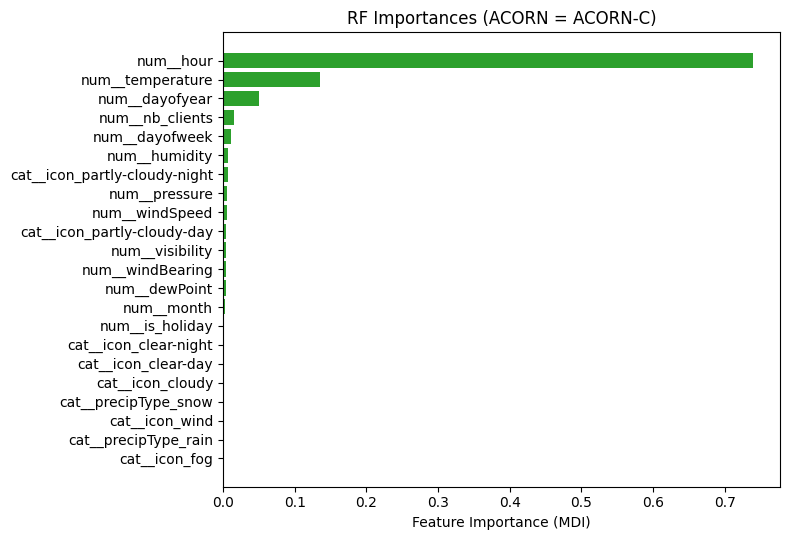

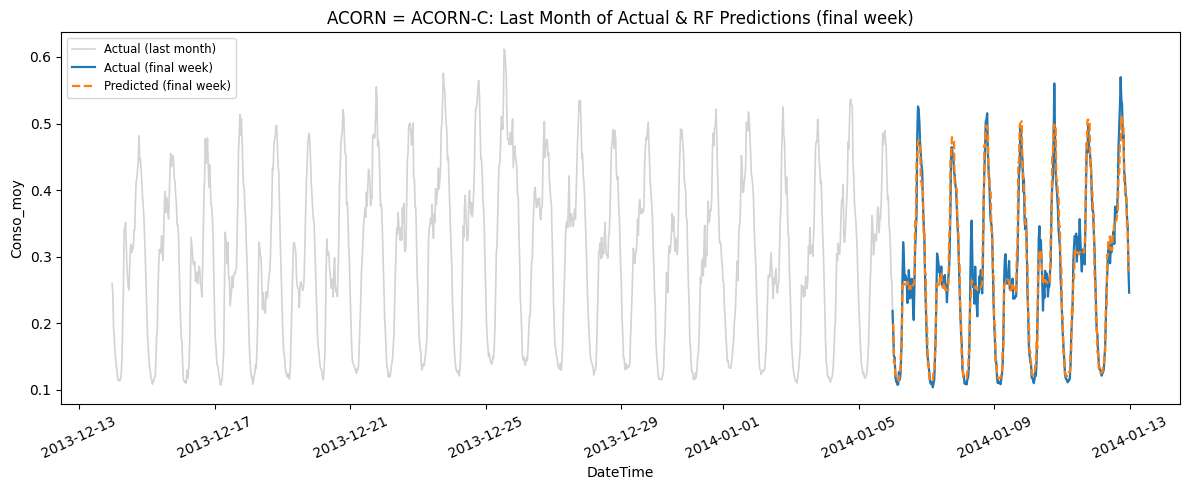


--- Best RF Feature Importances for ACORN = ACORN-F ---
  Top 10 features by importance:
    num__hour                       0.7030
    num__temperature                0.1889
    num__dayofyear                  0.0492
    num__dayofweek                  0.0192
    num__nb_clients                 0.0071
    num__windSpeed                  0.0046
    num__pressure                   0.0042
    num__dewPoint                   0.0041
    num__humidity                   0.0040
    num__visibility                 0.0038


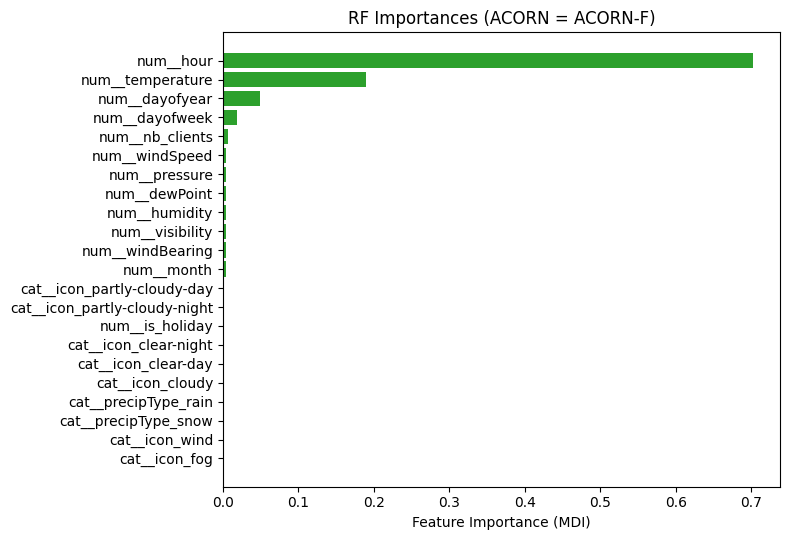

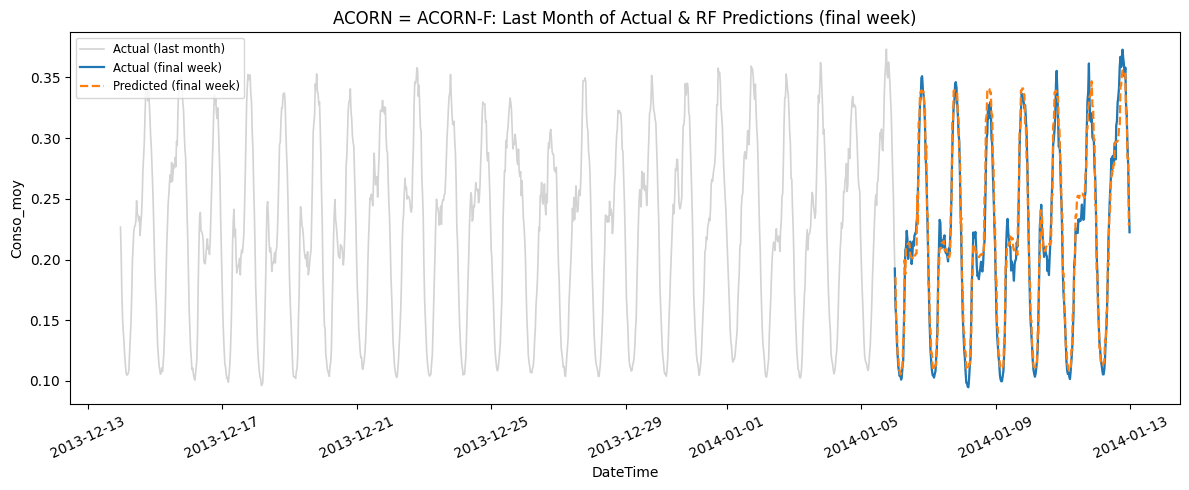


--- Best RF Feature Importances for ACORN = ACORN-P ---
  Top 10 features by importance:
    num__hour                       0.5882
    num__temperature                0.0688
    num__dayofyear                  0.0549
    num__dewPoint                   0.0426
    num__nb_clients                 0.0409
    num__month                      0.0380
    num__pressure                   0.0228
    num__visibility                 0.0223
    num__windSpeed                  0.0218
    num__windBearing                0.0210


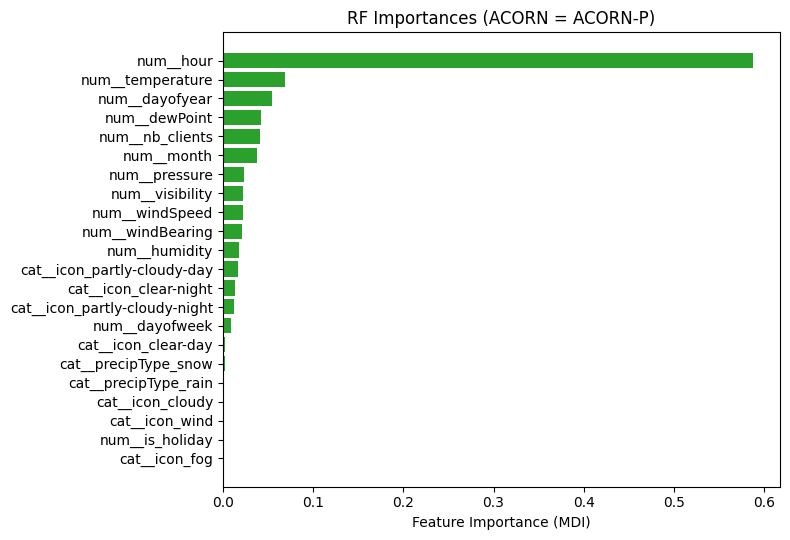

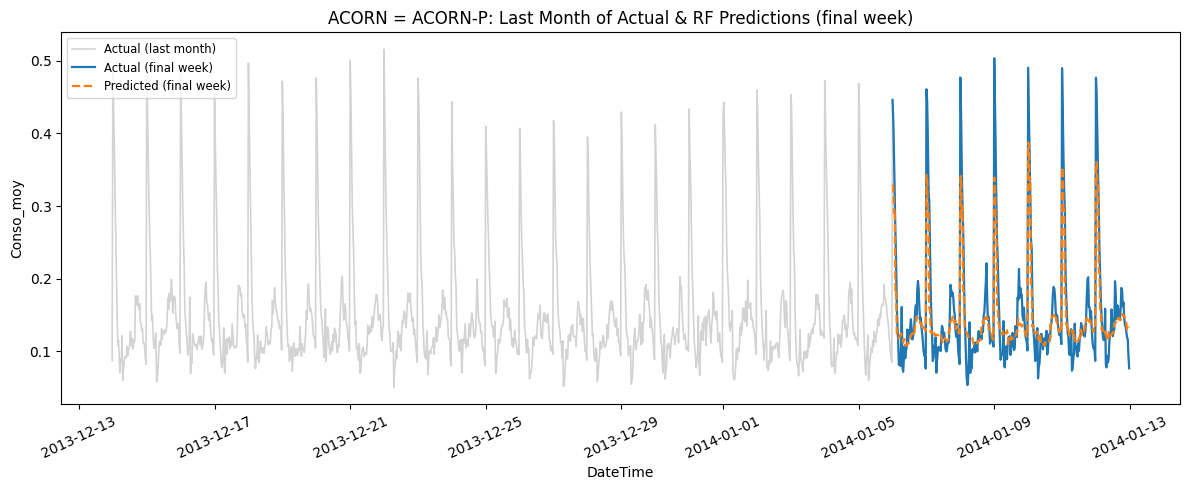

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) FEATURE IMPORTANCE AND PLOTTING LAST MONTH PER ACORN
# ──────────────────────────────────────────────────────────────────────────────
for acorn_label, info in results_rf.items():
    # 6.A) FEATURE IMPORTANCE
    print(f"\n--- Best RF Feature Importances for ACORN = {acorn_label} ---")
    pipe    = info["pipeline"]
    preproc = pipe.named_steps["preproc"]
    rf_mod  = pipe.named_steps["rf"]
    
    # 6.A.1) Retrieve post‐transform feature names
    feature_names = preproc.get_feature_names_out()
    importances   = rf_mod.feature_importances_
    idx_sorted    = np.argsort(importances)[::-1]
    
    print("  Top 10 features by importance:")
    for i in idx_sorted[:10]:
        print(f"    {feature_names[i]:<30}  {importances[i]:0.4f}")
    
    # 6.A.2) Plot all importances
    n_features = len(feature_names)
    plt.figure(figsize=(8, n_features * 0.25))
    plt.barh(
        np.arange(n_features),
        importances[idx_sorted],
        align="center",
        color="C2"
    )
    plt.yticks(np.arange(n_features), feature_names[idx_sorted])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (MDI)")
    plt.title(f"RF Importances (ACORN = {acorn_label})")
    plt.tight_layout()
    plt.show()
    
    # 6.B) PLOT LAST MONTH WITH FINAL WEEK’S PREDICTIONS
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    one_month_ago  = last_timestamp - pd.Timedelta(days=30)
    last_month_df  = full_group[full_group["DateTime"] >= one_month_ago].reset_index(drop=True)
    
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    plt.figure(figsize=(12, 5))
    # Actual last month (light gray)
    plt.plot(
        last_month_df["DateTime"],
        last_month_df["Conso_moy"],
        label="Actual (last month)",
        color="lightgray",
        linewidth=1.2
    )
    # Actual final week (solid blue)
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    # Predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Month of Actual & RF Predictions (final week)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

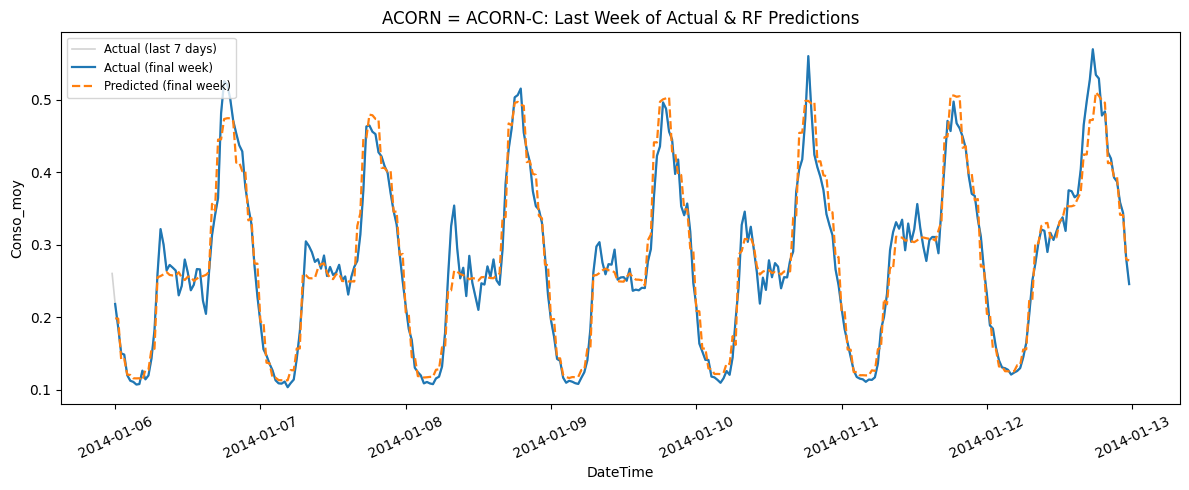

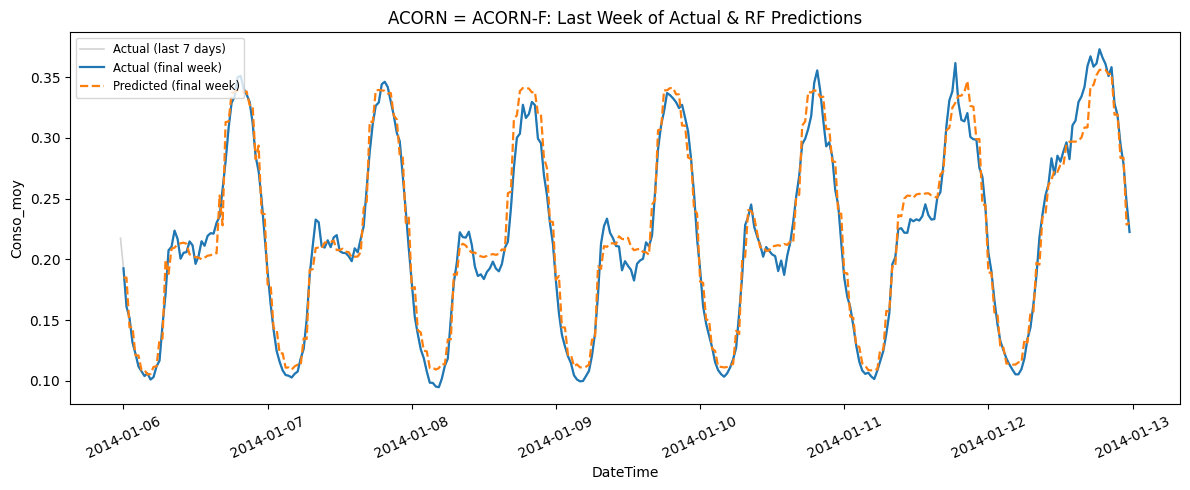

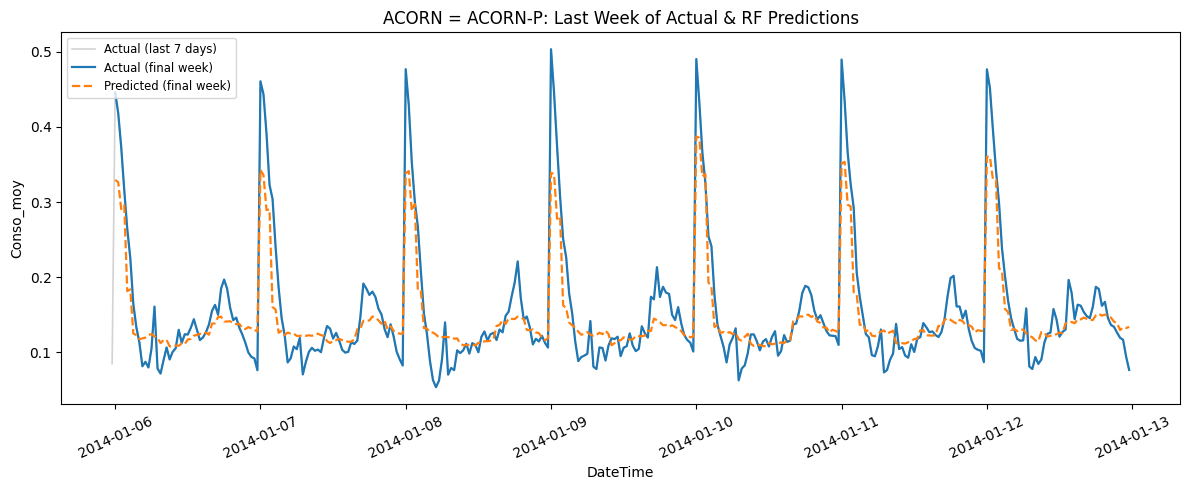

In [35]:
# ──────────────────────────────────────────────────────────────────────────────
# Plot only the last week of actual consumption and overlay the final week’s RF predictions
# ──────────────────────────────────────────────────────────────────────────────

for acorn_label, info in results_rf.items():
    # 1) Full history for this ACORN, sorted by DateTime
    full_group     = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = full_group["DateTime"].max()
    
    # 2) Compute one week ago
    one_week_ago = last_timestamp - pd.Timedelta(days=7)
    
    # 3) Filter to only the last 7 days of actual consumption
    last_week_df = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    # 4) Extract the final week test subset and its predictions
    sub_test = info["df_test_sub"].sort_values("DateTime").reset_index(drop=True)
    y_pred   = info["y_pred_sub"]
    
    # 5) Plot
    plt.figure(figsize=(12, 5))
    
    # 5A) Last 7 days actual (light gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="lightgray",
        linewidth=1.2
    )
    
    # 5B) Actual final week (solid blue) – these 7 days include the last week
    plt.plot(
        sub_test["DateTime"],
        sub_test["Conso_moy"],
        label="Actual (final week)",
        color="C0",
        linewidth=1.6
    )
    
    # 5C) RF predicted final week (dashed orange)
    plt.plot(
        sub_test["DateTime"],
        y_pred,
        label="Predicted (final week)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last Week of Actual & RF Predictions")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


In [146]:
pred_cons = pd.read_parquet(r'..\data\02_processed\parquet\group_4_half_hourly_predict.parquet')

In [147]:
pred_df = create_features(df_weather_hourly, pred_cons)


In [148]:
for acorn_label in pred_df.Acorn.unique():
    pred_acorn = pred_df[pred_df.Acorn == acorn_label].sort_values(by='DateTime').drop(columns='DateTime')
    pred_acorn = pred_acorn.drop(columns=['Acorn','day_of_week', 'Conso_moy_predict'])
    indexes = pred_cons[pred_cons.Acorn == acorn_label].index
    pred_cons.loc[indexes, 'Conso_moy_predict'] = results_rf[acorn_label]['pipeline'].predict(pred_acorn)

In [155]:
pred_cons.to_parquet(r'..\data\02_processed\parquet\group_4_half_hourly_predict_rf.parquet', index=False)

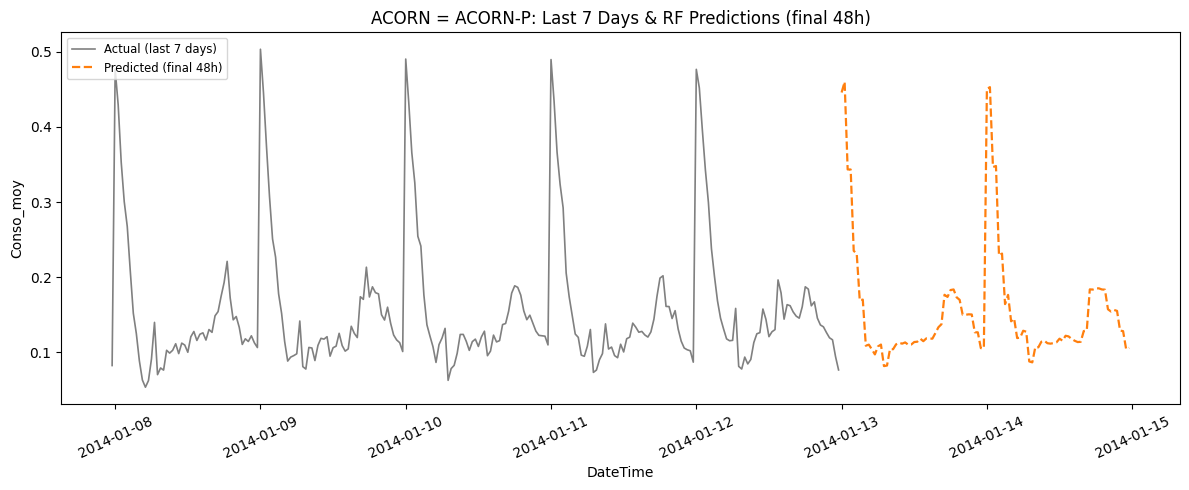

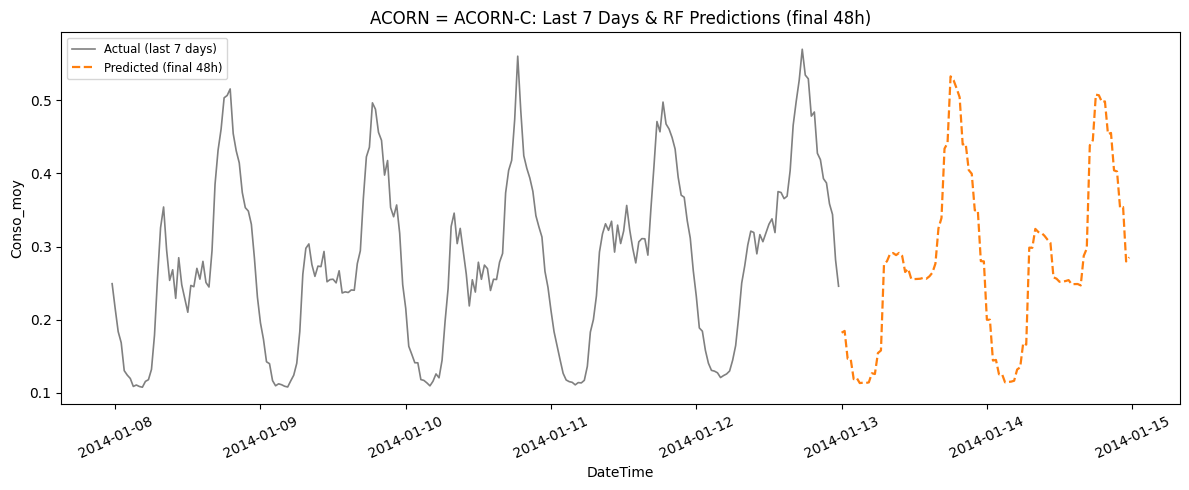

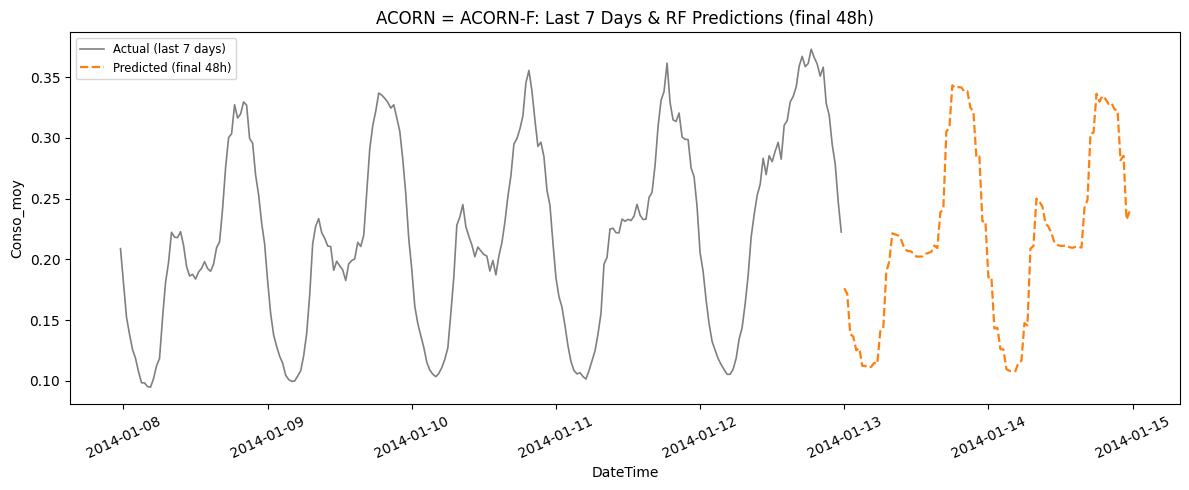

In [154]:
# 6.B) PLOT LAST 7 DAYS WITH FINAL 48h PREDICTIONS
for acorn_label in pred_df.Acorn.unique():
    full_group    = df[df["Acorn"] == acorn_label].sort_values("DateTime").reset_index(drop=True)
    last_timestamp = pred_df["DateTime"].max()
    one_week_ago   = last_timestamp - pd.Timedelta(days=7)
    last_week_df   = full_group[full_group["DateTime"] >= one_week_ago].reset_index(drop=True)
    
    plt.figure(figsize=(12, 5))
    # Actual last 7 days (gray)
    plt.plot(
        last_week_df["DateTime"],
        last_week_df["Conso_moy"],
        label="Actual (last 7 days)",
        color="gray",
        linewidth=1.2
    )
    # Actual final 48h (blue)
    # Predicted final 48h (dashed orange)
    plt.plot(
        pred_cons[pred_cons.Acorn == acorn_label]["DateTime"],
        pred_cons[pred_cons.Acorn == acorn_label]["Conso_moy_predict"],
        label="Predicted (final 48h)",
        color="C1",
        linestyle="--",
        linewidth=1.6
    )
    plt.xlabel("DateTime")
    plt.ylabel("Conso_moy")
    plt.title(f"ACORN = {acorn_label}: Last 7 Days & RF Predictions (final 48h)")
    plt.legend(loc="upper left", fontsize="small")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()